In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm.notebook import tqdm

In [2]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


@jit(nopython = True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [6]:
from scipy.special import erfinv
import scipy.stats as scs
from scipy.stats import mode

In [4]:
@jit(nopython = True)
def Kuramoto(Theta,t,omega,N,Aij):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Aij*np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

In [7]:
N = 80
omega = 0
seed = 11
# np.random.seed(seed)
theta_random = np.random.uniform(-np.pi, np.pi, size=N)
# omega = np.sort(omega)-np.mean(omega)
# omega = np.ones(N)

In [8]:
Aij = np.zeros((N,N))
k =  2  # number of link
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= 1
    # Aij[i,i] = 0 

In [14]:
K = 1
t_end = 1000
dt = 0.01
theta_random = np.random.uniform(-np.pi, np.pi, size=N)
t = np.arange(0, t_end+dt/2, dt)
b = 1.01

In [15]:
sol = RK4(Kuramoto,theta_random,t, args=(omega,N,Aij))

In [16]:
theta_s = sol[:,:N]
dtheta_s = sol[:,N:2*N] 

In [21]:
np.diff((theta_s[-1]+np.pi)%(np.pi*2)-np.pi)

array([ 0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963, -6.12610567,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15707963,
        0.15707963, -6.12610567,  0.15707963,  0.15707963,  0.15707963,
        0.15707963,  0.15707963,  0.15707963,  0.15707963,  0.15

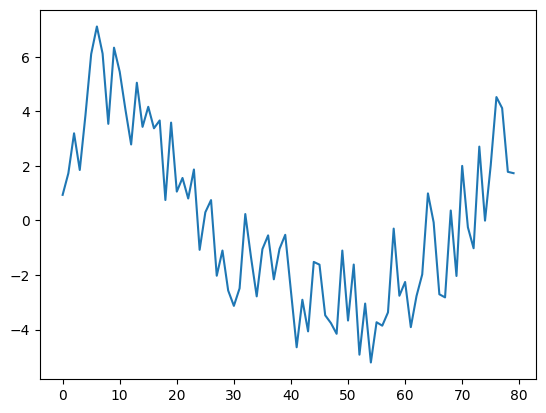

In [18]:
plt.plot(theta_s[-1]-theta_s[0])

In [373]:
rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
rs = np.abs(rphi)
phi = np.angle(rphi)

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [432]:
Qs = [] 
rs = []

In [433]:
# Qs = [] 
for i in tqdm(range(5000)):
    t_end = 1000
    dt = 0.1
    theta_random = np.random.uniform(-np.pi, np.pi, size=N)
    t = np.arange(0, t_end+dt/2, dt)
    sol = RK4(Kuramoto,theta_random,t, args=(omega,N,Aij))
    theta_s = sol[:,:N]
    dtheta_s = sol[:,N:2*N] 
    Q = mode(np.round(np.diff((theta_s[-1]-np.pi)%(np.pi*2)+np.pi) / (np.pi*2/N),1))[0]
    rphi = (np.mean(np.exp(1j*theta_s.T),axis=0))
    r = np.abs(rphi)
    rs.append(np.mean(rs[-500:]))
    Qs.append(*Q)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [434]:
np.savez(f'N={N},k={k}.npz', Qs = Qs,rs = rs)

In [412]:
A = []
for Q in Qs:
    A.append(*Q)

<BarContainer object of 9 artists>

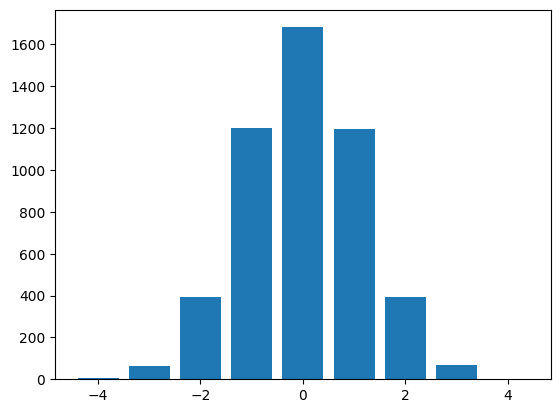

In [435]:
plt.bar(*np.unique(Qs, return_counts=True))

In [16]:
from scipy.stats import norm

In [22]:
norm.pdf(6,0,1.61)*3600

0.8601399897901175

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 31.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([-3.  , -2.94, -2.88, -2.82, -2.76, -2.7 , -2.64, -2.58, -2.52,
        -2.46, -2.4 , -2.34, -2.28, -2.22, -2.16, -2.1 , -2.04, -1.98,
        -1.92, -1.86, -1.8 , -1.74, -1.68, -1.62, -1.56, -1.5 , -1.44,
        -1.38, -1.32, -1.26, -1.2 , -1.14, -1.08, -1.02, -0.96, -0.9 ,
        -0.84, -0.78, -0.72, -0.66, -0.6 , -0.54, -0.48, -0.42, -0.36,
        -0.3 , -0.24, -0.18, -0.12, -0.06,  0.  ,  0.06,  0.12,  0.18,
        

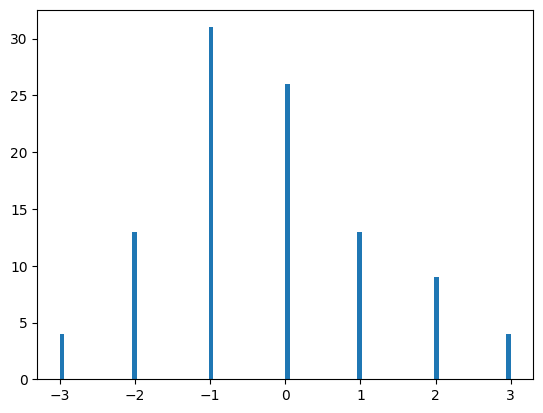

In [400]:
plt.hist(A,bins=100)

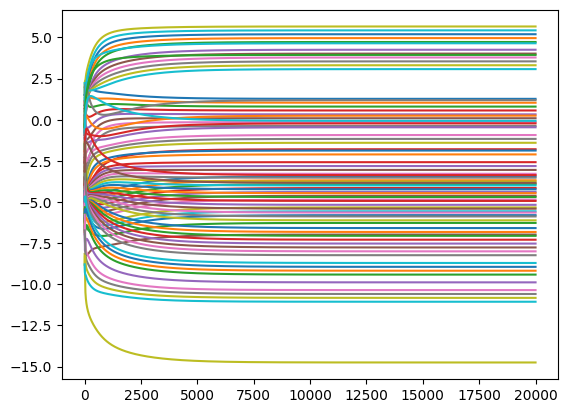

In [347]:
plt.plot((theta_s-(np.pi*2*np.arange(N)/N)))

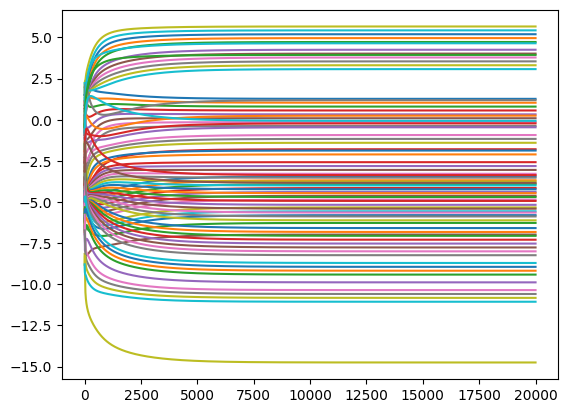

In [345]:
plt.plot(theta_s-(np.pi*2*np.arange(N)/N))

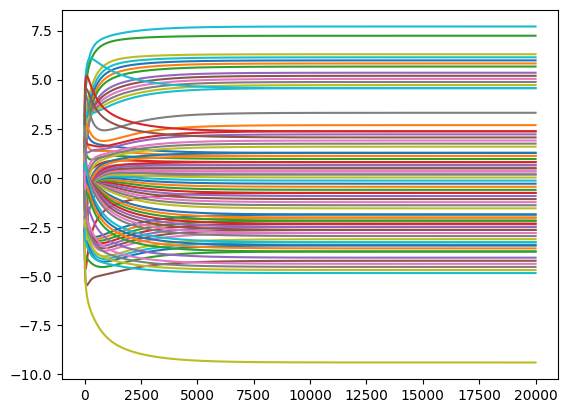

In [334]:
plt.plot(theta_s-)#-phi.reshape(-1,1))

(array([ 1.,  0.,  4., 15., 15., 17., 12.,  2., 10.,  4.]),
 array([-127. , -105.2,  -83.4,  -61.6,  -39.8,  -18. ,    3.8,   25.6,
          47.4,   69.2,   91. ]),
 <BarContainer object of 10 artists>)

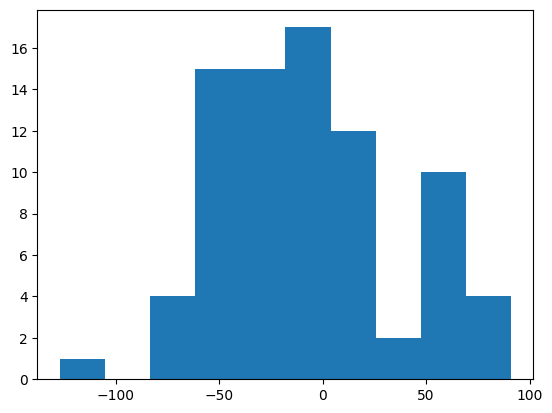

In [336]:
plt.hist((theta_s[-1]-phi[-1])//(2*np.pi/N))

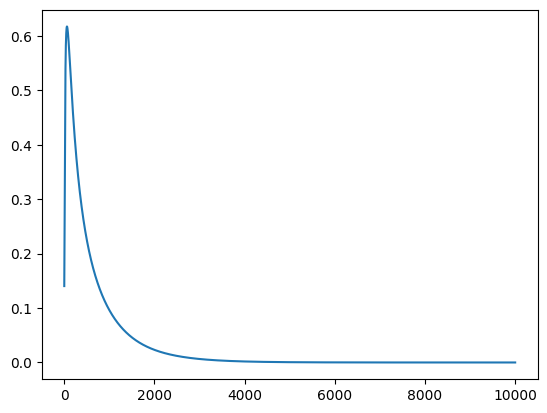

In [283]:
plt.plot(rs)

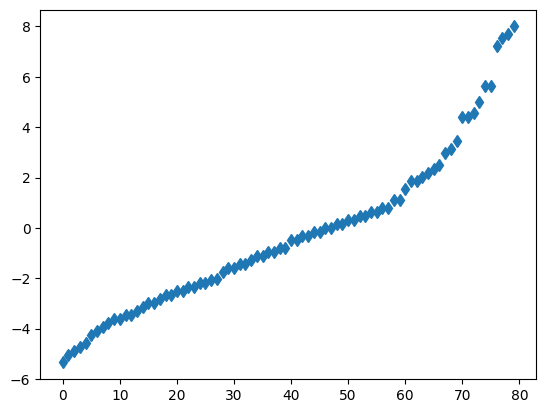

In [287]:
plt.plot(np.sort(theta_s[-1]),'d')

(array([ 8.,  7., 13.,  6.,  9., 15.,  6.,  5.,  7.,  4.]),
 array([-3.11214884, -2.48809358, -1.86403833, -1.23998307, -0.61592782,
         0.00812744,  0.63218269,  1.25623795,  1.8802932 ,  2.50434845,
         3.12840371]),
 <BarContainer object of 10 artists>)

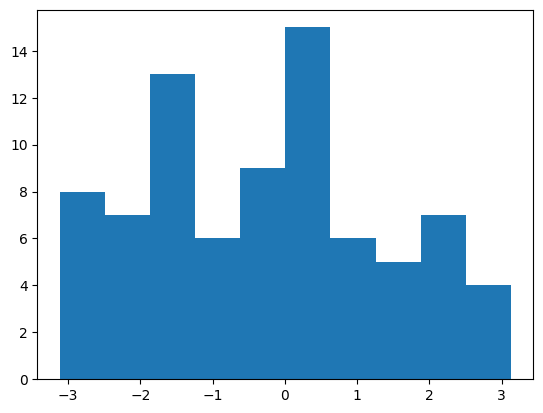

In [288]:
plt.hist(((theta_s[-1]-theta_s[0])+np.pi)%(np.pi*2)-np.pi)

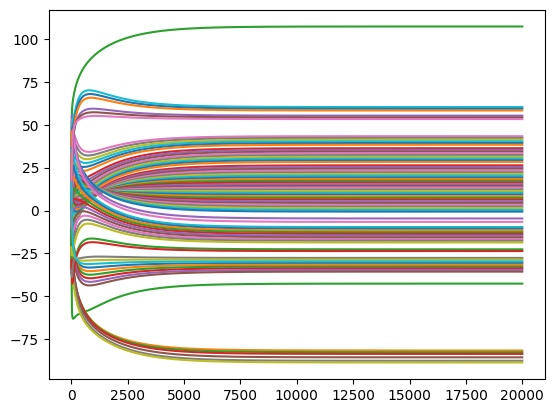

In [240]:
plt.plot(theta_s/(2*np.pi/N))

(array([ 6.,  0.,  7., 14., 13., 19., 14.,  6.,  0.,  1.]),
 array([-88.64322395, -69.04325241, -49.44328088, -29.84330935,
        -10.24333781,   9.35663372,  28.95660525,  48.55657679,
         68.15654832,  87.75651985, 107.35649139]),
 <BarContainer object of 10 artists>)

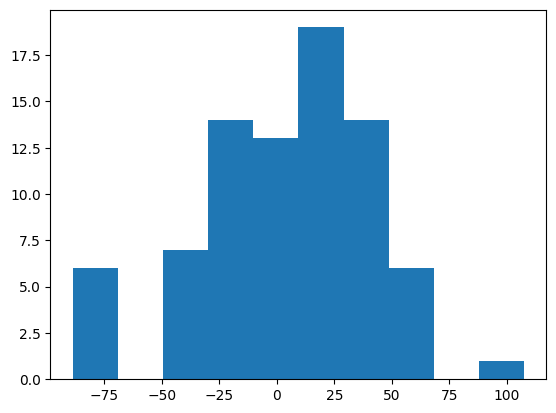

In [241]:
plt.hist(np.sort(theta_s[-1])/(2*np.pi/N))

(array([2., 2., 2., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 2., 0., 2., 2.,
        0., 2., 2., 2., 2., 1., 1., 0., 0., 0., 2., 2., 2., 2., 1., 1., 3.,
        2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-91.0900031 , -89.07000638, -87.05000966, -85.03001294,
        -83.01001621, -80.99001949, -78.97002277, -76.95002605,
        -74.93002932, -72.9100326 , -70.89003588, -68.87003916,
        -66.85004243, -64.83004571, -62.81004899, -60.79005227,
        -58.77005554, -56.75005882, -54.7300621 , -52.71006538,
        -50.69006866, -48.67007193, -46.65007521, -44.63007849,
        -42.61008177, -40.59008504, -38.57008832, -36.5500916 ,
        -34.53009488, -32.51009815, -30.49010143, -28.47010471,
        -26.45010799, -24.43011126, -2

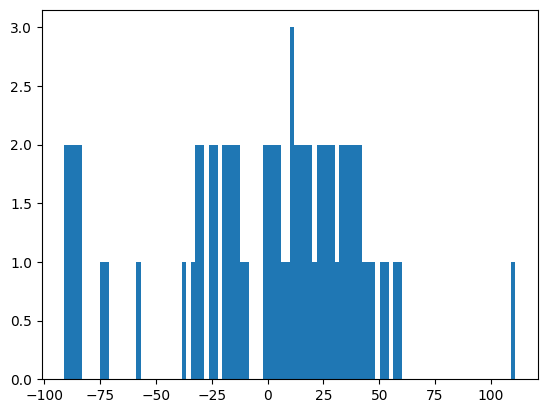

In [208]:
plt.hist((theta_s[-1])/(2*np.pi/N),bins=100)

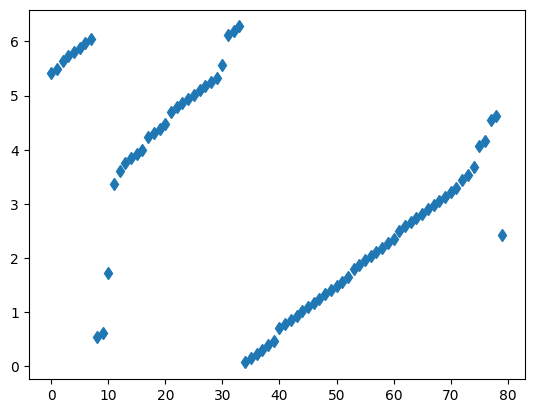

In [209]:
plt.plot(np.sort(theta_s[-1])%(2*np.pi),'d')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 78.]),
 array([-6.204646  , -5.57632731, -4.94800862, -4.31968993, -3.69137124,
        -3.06305256, -2.43473387, -1.80641518, -1.17809649, -0.5497778 ,
         0.07854089]),
 <BarContainer object of 10 artists>)

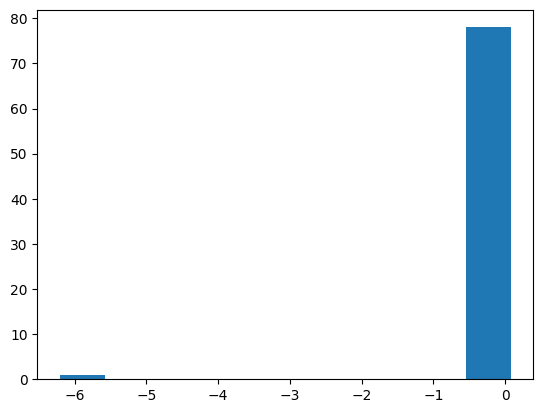

In [210]:
plt.hist(np.diff(theta_s[-1]%(np.pi*2)))

In [2]:
import Ensemble
import parmap
import numpy as np
import matplotlib.pyplot as plt

In [3]:
t_end = 1000
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)

In [4]:

import warnings
warnings.filterwarnings(action='ignore')

In [10]:
N = 80
k =  80  # number of link
Aij = np.zeros((N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= 1
    # Aij[i,i] = 0 
Qs_N = []
rs_N = []
for Q,r in parmap.map(Ensemble.get_Qr,np.arange(1000),t,N,Aij,pm_processes=12,pm_pbar=True):
    Qs_N.append(*Q)
    rs_N.append(r)
plt.bar(*np.unique(Qs_N, return_counts=True))
plt.plot(r)
plt.show()
np.savez(f'N={N},k={k}.npz', Qs = Qs_N,rs = rs_N)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

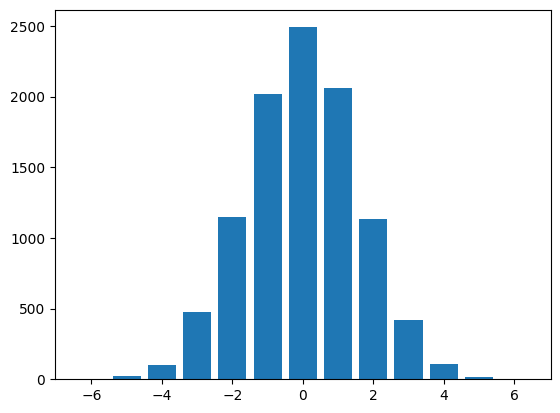

In [5]:
N = 80
k =  1  # number of link
Aij = np.zeros((N,N))
for i in range(N):
    j = np.arange((i-k),(i+k+1),1)%N
    Aij[i,j]= 1
    # Aij[i,i] = 0 
Qs_N = []
rs_N = []
for Q,r in parmap.map(Ensemble.get_Qr,np.arange(10000),t,N,Aij,pm_processes=12,pm_pbar=True):
    Qs_N.append(*Q)
    rs_N.append(r)
    import matplotlib.pyplot as plt
plt.bar(*np.unique(Qs_N, return_counts=True))
plt.plot(r)
plt.show()
np.savez(f'dt=0.01/N={N},k={k} 3.npz', Qs = Qs_N,rs = rs_N)

In [14]:
np.savez(f'dt=0.01/N={N},k={k}.npz', Qs = Qs_N,rs = rs_N)


In [ ]:
len(Qs_N)

In [30]:
np.savez(f'dt=0.01/N={N},k={k}.npz', Qs = Qs,rs = rs)

In [7]:
N = 80
k = 1

In [9]:
A = np.load(f'dt=0.01/N={N},k={k} 3.npz')
B = np.load(f'dt=0.01/N={N},k={k} 2.npz')
D = np.load(f'dt=0.01/N={N},k={k} 4.npz')
E = np.load(f'dt=0.01/N={N},k={k} 5.npz')
# C = np.loadz(f'dt=0.01/N={N},k={k} 1.npz')
C = np.load(f'dt=0.01/N={N},k={k}.npz')

In [10]:
Qs = [*A['Qs']]
rs = [*A['rs']]

In [11]:
Qs += [*B['Qs']]
Qs += [*C['Qs']]
Qs += [*D['Qs']]
Qs += [*E['Qs']]


rs += [*B['rs']]
rs += [*C['rs']]
rs += [*D['rs']]
rs += [*E['rs']]

In [12]:
len(Qs)

105000

<BarContainer object of 14 artists>

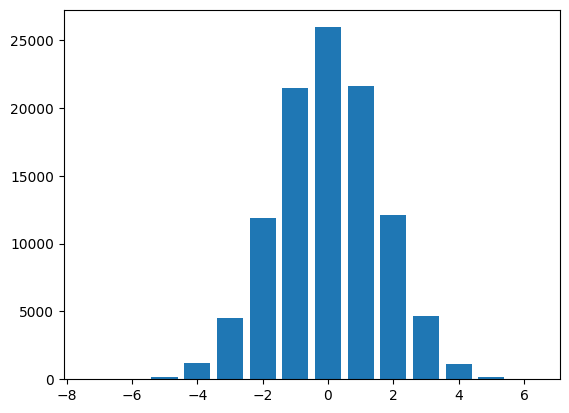

In [13]:
plt.bar(*np.unique(Qs, return_counts=True))
# plt.plot(r)
# plt.show()
# np.savez(f'dt=0.01/N={N},k={k}.npz', Qs = Qs_N,rs = rs_N)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

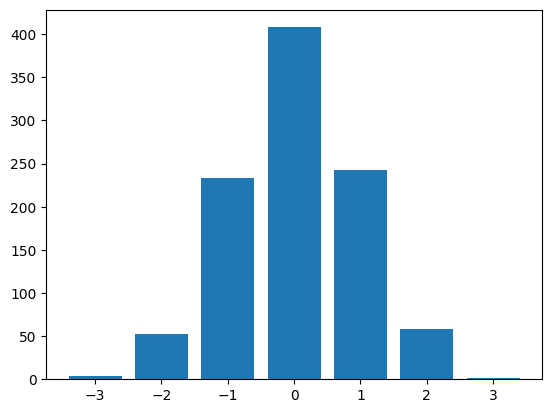

  0%|          | 0/1000 [00:00<?, ?it/s]

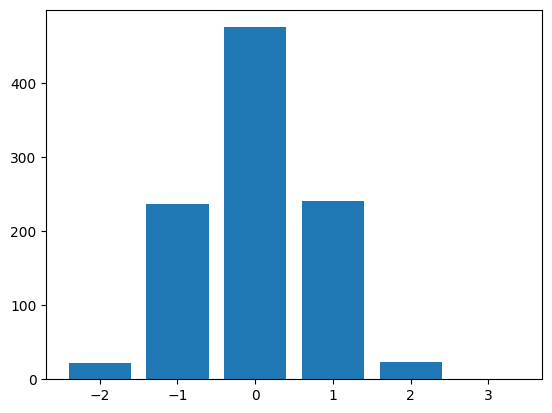

  0%|          | 0/1000 [00:00<?, ?it/s]

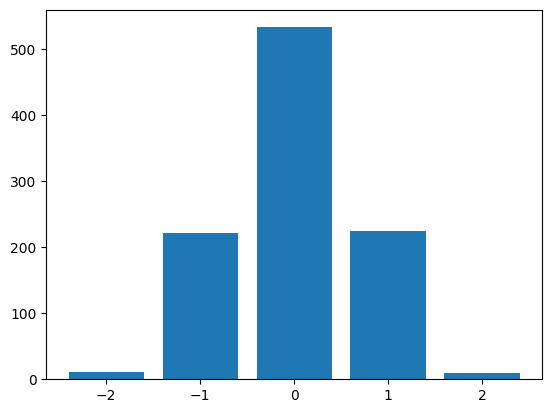

  0%|          | 0/1000 [00:00<?, ?it/s]

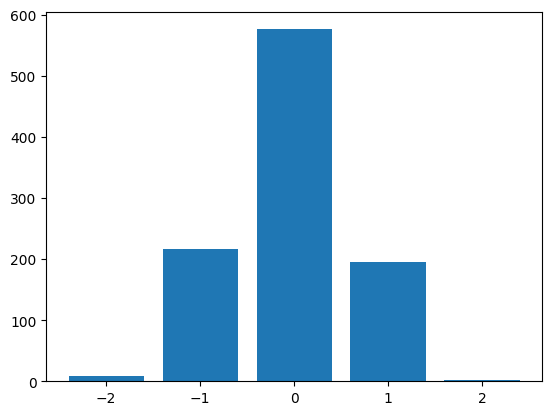

  0%|          | 0/1000 [00:00<?, ?it/s]

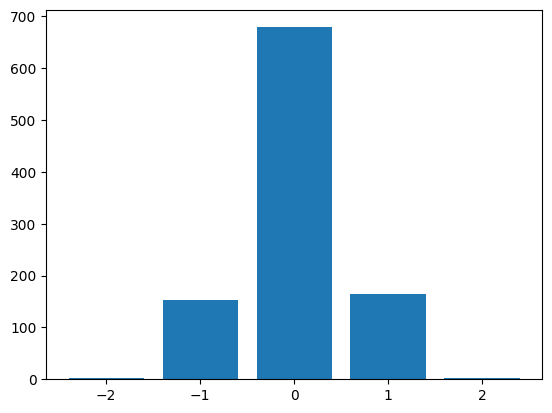

  0%|          | 0/1000 [00:00<?, ?it/s]

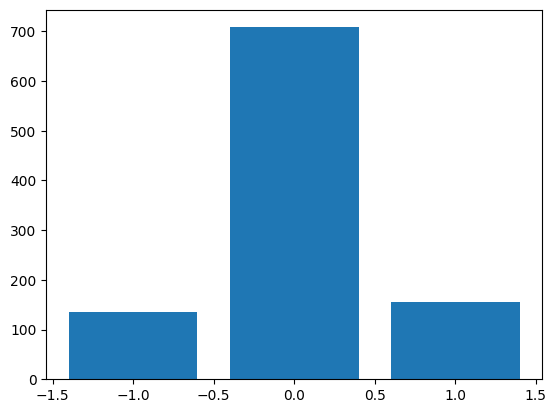

  0%|          | 0/1000 [00:00<?, ?it/s]

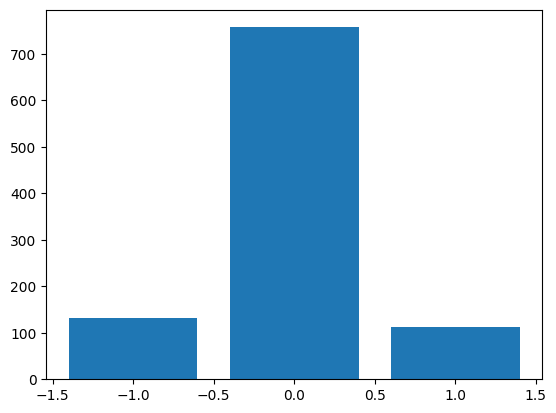

  0%|          | 0/1000 [00:00<?, ?it/s]

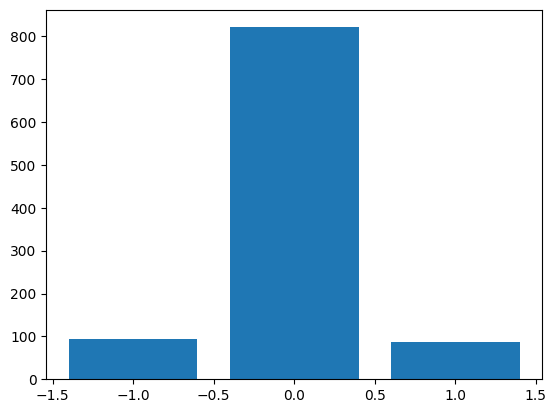

  0%|          | 0/1000 [00:00<?, ?it/s]

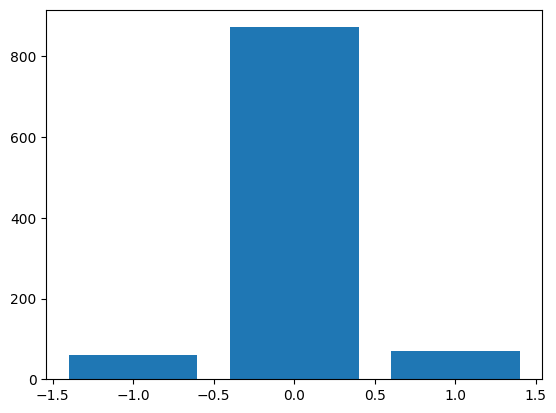

In [19]:
N = 60
# k =  4  # number of link
for k in tqdm(range(2,11)):
    Aij = np.zeros((N,N))
    for i in range(N):
        j = np.arange((i-k),(i+k+1),1)%N
        Aij[i,j]= 1
        # Aij[i,i] = 0 
    Qs_N = []
    rs_N = []
    for Q,r in parmap.map(Ensemble.get_Qr,np.arange(1000),t,N,Aij,pm_processes=16,pm_pbar=True):
        Qs_N.append(*Q)
        rs_N.append(r)
    plt.bar(*np.unique(Qs_N, return_counts=True))
    plt.plot(r)
    plt.show()
    np.savez(f'dt=0.01/N={N},k={k}.npz', Qs = Qs_N,rs = rs_N)

In [15]:
np.mean(rs_N)

0.2954489756340325

## Q rs qraph

In [23]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [30]:
ITEM = glob.glob('Q_state/Q=-*.npy')

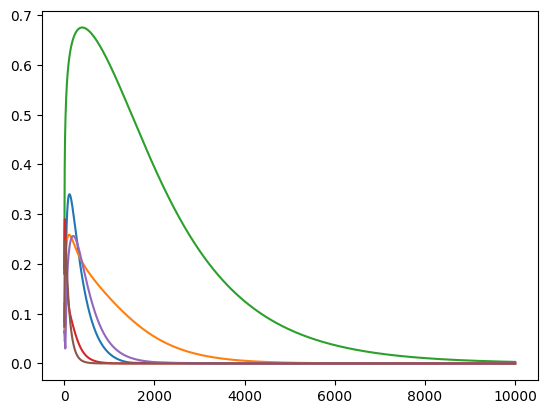

In [31]:
for Q in ITEM:
    A = np.load(Q)
    plt.plot(A)

In [65]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
curvefit = scipy.optimize.curve_fit
def fitting(x,sigma):
    norm = scipy.stats.norm.pdf
    return norm(x,0,sigma)

In [86]:
N = 80
R2_m = []
R2_s = []
R2_std = []
INDEXS = []
DS = []
ks =  np.arange(1,N+1)
S_s = []
Q_idx = np.arange(-7,7,1)
INDEX_kQ = Q_idx.reshape(-1,1)*np.zeros((1,N)) 
for i in range(1,N+1):
    
    A = np.load(f'dt=0.01/N={N},k={i}.npz')
    rs = A['rs']
    Qs = A['Qs']
    INDEX, A = np.unique(Qs,return_counts=True)
    D = A/np.sum(A)
    DS.append(D)
    for idx,d in zip(INDEX,D):
        INDEX_kQ[int(idx)+7,i-1] = d
    INDEXS.append(INDEX)
    
    r_std = np.std(rs)
    r_m = np.mean(rs)
    R2_m.append(r_m)
    R2_s.append(rs)
    R2_std.append(r_std)
    popt, pcov  = curvefit(fitting,INDEX,D)
    S_s.append(*popt)
S_s = np.array(S_s)

In [ ]:

N = 80
R_m = []
R_s = []
R_std = []
S_s = []
for i in range(1,N+1):
    
    A = np.load(f'dt=0.01/N={N},k={i}.npz')
    rs = A['rs']
    Qs = A['Qs']
    r_std = np.std(rs)
    r_m = np.mean(rs)
    R_m.append(r_m)
    R_s.append(rs)
    R_std.append(r_std)
    Q,C = np.unique(Qs, return_counts=True)
    P = C/ np.sum(C)



In [59]:
INDEX

array([-5., -4., -3., -2., -1., -0.,  1.,  2.,  3.,  4.,  5.])

In [84]:
INDEXS

[array([-6., -5., -4., -3., -2., -1., -0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 array([-3., -2., -1., -0.,  1.,  2.,  3.]),
 array([-2., -1.,  0.,  1.,  2.]),
 array([-2., -1.,  0.,  1.,  2.]),
 array([-2., -1., -0.,  1.,  2.]),
 array([-2., -1., -0.,  1.,  2.]),
 array([-1., -0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1., -0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([0., 1.]),
 array([-0.,  1.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([-0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array(

(1.0, 20.0)

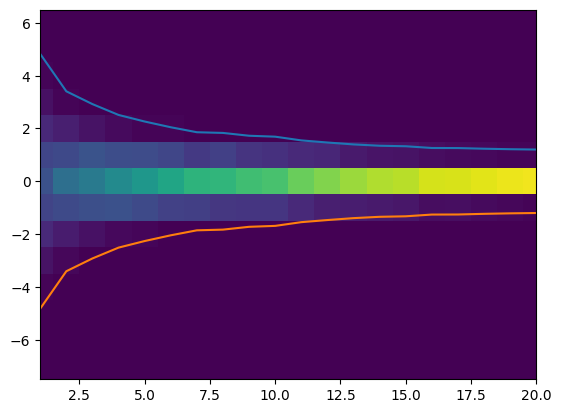

In [89]:
plt.pcolormesh(ks,Q_idx,INDEX_kQ)#,aspect='auto')
plt.plot(ks,3*S_s)
plt.plot(ks,-3*S_s)
plt.xlim(1,20)

In [50]:
len(INDEX_kQ[0])

60